# Modeling 2: Logistic Regression and K-Nearest Neighbors

- **Author**: Dan O'Connor
- **Notebook**: 5 of 9

In this notebook I will continue with model testing. I use logistic regression and K-Nearest Neighbors (KNN). I continue to save their success metrics in their respective dataframes. I will perform a model analysis in notebook 9 where I take an in depth look.

## Table of Contents
[Logistic Regression](#Logistic-Regression)

[KNN](#KNN)


import required libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive #working in google colab

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


Reading in the modeling dataframe as well as the success metrics dataframes.

In [4]:
subset_model_df = pd.read_csv('Data/subset_model_df.csv')

In [23]:
accuracy_df = pd.read_csv('Data/accuracy_df1.csv', index_col='Model')

In [24]:
scores_df = pd.read_csv('Data/scores_df1.csv', index_col = 'Genres')

Split the independent and dependent variables and label encode the independent then split into training and testing set (using the same random state as before, so the models can be directly comparable).

In [5]:
X = subset_model_df.drop(columns='genre_top')
y = subset_model_df['genre_top']

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encoder object
label_encoder = LabelEncoder()

# Fit the encoder on y
label_encoder.fit(y)

# Transform
y_encoded = label_encoder.transform(y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.25, stratify=y,random_state=1)

In [87]:
y_train # a look into classes 0-8

array([1, 7, 1, ..., 1, 2, 2])

In [8]:
from my_functions import get_class_metrics #importing class_metrics function

## Logistic Regression

For multiple classes, a logistic regression takes a one versus all approach, effectively making it a binary classifaction run multiple times. For example when classifying rock, it would view:
- rock vs. (folk + classical + pop + international + experimental + electronic + hip hop + instrumental)

Below I run the baseline for log regression. I first fit the standard scaler to my X_train then transform it to X_test. This ensures there is no data leakage. I fit the model on the X_train_scaled and y_train and use a random state for reproducability.

In [9]:
import warnings
warnings.filterwarnings("ignore") #clear up the output for viewers sake

In [10]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# create a new StandardScaler
scaler = StandardScaler()

# fit the scale
scaler.fit(X_train)

# transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train a logistic regression classifier
lr = LogisticRegression(random_state=1)
lr.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = lr.predict(X_test_scaled)

# Calculate accuracy
baseline_accuracy_lr = accuracy_score(y_test, y_pred)
print("Accuracy:", baseline_accuracy_lr)
baseline_lr_class_report = classification_report(y_test,y_pred,output_dict=True)

Accuracy: 0.6583109017496636


In [96]:
lr.score(X_train_scaled,y_train)

0.6754157202546199

In [26]:
accuracy_df.loc['Logistic Regression', 'Baseline Accuracy'] = round(baseline_accuracy_lr,2) #add to df

In [27]:
accuracy_df

,Baseline Accuracy,Optimized Accuracy
Model,,
Baseline,0.29,NaN
Logistic Regression,0.66,NaN
KNN,NaN,NaN
Random Forest,0.64,0.64
Decision Tree,0.47,0.52
Neural Net,NaN,NaN
SMOTE Neural Net,NaN,NaN


In [28]:
get_class_metrics(baseline_lr_class_report, 'baseline_lr', scores_df) #get success metrics

Below I am utilizing a grid search for the optimal hyperparameters for my logistic regression. I try two different scaling options, a logarithmic series of C values, and two different penalties.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('scaling', None),
    ('model', LogisticRegression())
])

#parameter grid
param_grid = {
    'scaling': [MinMaxScaler(), StandardScaler()],
    'model__C': [0.001,0.01, 0.1, 1, 10,100],
    'model__penalty': ['l1', 'l2']
}

#cross-val
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# gridSearch object
grid_search = GridSearchCV(pipeline, param_grid, cv=cv,verbose=3)

# Fit the GridSearchobject on training data
grid_search.fit(X_train, y_train)

# Evaluate the best model 
best_model_lr = grid_search.best_estimator_
y_pred = best_model_lr.predict(X_test)
optimized_score_lr = best_model_lr.score(X_test, y_test)
print('Accuracy: ', optimized_score_lr)
optimized_lr_class_report = classification_report(y_test,y_pred,output_dict=True)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END model__C=0.001, model__penalty=l1, scaling=MinMaxScaler();, score=nan total time=   0.3s
[CV 2/3] END model__C=0.001, model__penalty=l1, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 3/3] END model__C=0.001, model__penalty=l1, scaling=MinMaxScaler();, score=nan total time=   0.4s
[CV 1/3] END model__C=0.001, model__penalty=l1, scaling=StandardScaler();, score=nan total time=   0.7s
[CV 2/3] END model__C=0.001, model__penalty=l1, scaling=StandardScaler();, score=nan total time=   0.4s
[CV 3/3] END model__C=0.001, model__penalty=l1, scaling=StandardScaler();, score=nan total time=   0.3s
[CV 1/3] END model__C=0.001, model__penalty=l2, scaling=MinMaxScaler();, score=0.478 total time=  18.6s
[CV 2/3] END model__C=0.001, model__penalty=l2, scaling=MinMaxScaler();, score=0.472 total time=  10.0s
[CV 3/3] END model__C=0.001, model__penalty=l2, scaling=MinMaxScaler();, score=0.473 total time=   9.4s
[CV 1/3] 

In [29]:
print(best_model_lr)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', LogisticRegression(C=0.01))])


The model with the best hyperparameters is then fit and saved, with the success metrics saved as well.

In [12]:
from joblib import dump
lr = LogisticRegression(random_state=1, C=0.01 )
lr.fit(X_train_scaled, y_train)



dump(lr, 'logistic_regression_optimized.joblib') #save trained model

y_pred =lr.predict(X_test)

optimized_score_lr = lr.score(X_test_scaled, y_test)
print('Accuracy: ', optimized_score_lr)
optimized_lr_class_report = classification_report(y_test,y_pred,output_dict=True)

Accuracy:  0.6609185733512786


In [30]:
accuracy_df.loc['Logistic Regression', 'Optimized Accuracy'] = round(optimized_score_lr,2)
print('Accuracy: ', optimized_score_lr)

Accuracy:  0.6609185733512786


In [31]:
get_class_metrics(optimized_lr_class_report, 'optimized_lr',scores_df)

In [32]:
scores_df

,index,baseline_recall,baseline_f1,baseline_precision,baseline_dt_recall,baseline_dt_f1-score,baseline_dt_precision,optimized_dt_recall,optimized_dt_f1-score,optimized_dt_precision,...,baseline_rf_precision,optimized_rf_recall,optimized_rf_f1-score,optimized_rf_precision,baseline_lr_recall,baseline_lr_f1-score,baseline_lr_precision,optimized_lr_recall,optimized_lr_f1-score,optimized_lr_precision
Genres,,,,,,,,,,,,,,,,,,,,,
Classical,0,0.025893,0.025846,0.025840,0.500000,0.511628,0.523810,0.538961,0.549669,0.560811,...,0.855469,0.678862,0.743875,0.822660,0.762987,0.788591,0.815972,0.035714,0.057143,0.142857
Electronic,1,0.197050,0.197048,0.197078,0.456253,0.456740,0.457228,0.585574,0.513761,0.457638,...,0.587678,0.677695,0.632155,0.592351,0.663252,0.644546,0.626866,0.005975,0.011447,0.135922
Experimental,2,0.223475,0.223397,0.223354,0.443062,0.452707,0.462781,0.531297,0.489831,0.454370,...,0.556041,0.702168,0.615321,0.547593,0.680618,0.651742,0.625216,0.000377,0.000754,1.000000
Folk,3,0.058978,0.058946,0.058957,0.378031,0.375620,0.373239,0.339515,0.380192,0.431942,...,0.645570,0.516934,0.579421,0.659091,0.546362,0.570365,0.596573,0.000000,0.000000,0.000000
Hip-Hop,4,0.074407,0.074338,0.074309,0.384009,0.384442,0.384876,0.289414,0.364023,0.490458,...,0.803604,0.481690,0.614555,0.848635,0.668919,0.668919,0.668919,0.000000,0.000000,0.000000
Instrumental,5,0.043921,0.043933,0.043986,0.182692,0.175439,0.168739,0.148077,0.182681,0.238390,...,0.576923,0.141827,0.229126,0.595960,0.209615,0.267813,0.370748,0.000000,0.000000,0.000000
International,6,0.029491,0.029453,0.029457,0.256484,0.244505,0.233596,0.077810,0.135678,0.529412,...,0.937500,0.208633,0.340176,0.920635,0.412104,0.463533,0.529630,0.988473,0.057276,0.029493
Pop,7,0.048599,0.048621,0.048680,0.097770,0.093137,0.088924,0.000000,0.000000,0.000000,...,0.461538,0.006438,0.012685,0.428571,0.068611,0.111111,0.291971,0.000000,0.000000,0.000000
Rock,8,0.297893,0.297935,0.298007,0.651720,0.652640,0.653563,0.750141,0.700922,0.657765,...,0.715256,0.836447,0.757300,0.691837,0.835589,0.785005,0.740195,0.004512,0.008832,0.207792


## KNN

KKN is a classifcation model that stores all the training data to memory and then when prediciting takes the class majority vote for K number of nearest neighbors. It is a fairly simple algorithm, however, very computationally intensive. Below I run the baseline KNN (default k=5). I use the standard scaler from before to fit the model.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier() #inistantiate KNN
knn.fit(X_train_scaled,y_train) #fit on train scaled data

y_pred = knn.predict(X_test_scaled)

baseline_knn_accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", baseline_knn_accuracy)
baseline_knn_class_report = classification_report(y_test,y_pred,output_dict=True)

In [33]:
accuracy_df.loc['KNN', 'Baseline Accuracy'] = round(baseline_knn_accuracy,2)
print("Accuracy:", baseline_knn_accuracy)

Accuracy: 0.6222240915208613


In [34]:
get_class_metrics(baseline_knn_class_report, 'baseline_knn',scores_df)

For the grid search my parameter space consisted of two different scaling options, three different k's, and two weighting methods. I used cross validation as well.

In [14]:


pipeline = Pipeline([
    ('scaling', None),
    ('model', KNeighborsClassifier())
])

# parameter grid
param_grid = {
    'scaling': [MinMaxScaler(), StandardScaler()],
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance']
}

#cross-validation 
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# GridSearch object
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=3)

# Fit the GridSearch object 
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model_knn = grid_search.best_estimator_
y_pred_knn = best_model_knn.predict(X_test)
optimized_score_knn = best_model_knn.score(X_test, y_test)
print('Accuracy: ', optimized_score_knn)
optimized_knn_class_report = classification_report(y_test,y_pred_knn,output_dict=True)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END model__n_neighbors=3, model__weights=uniform, scaling=MinMaxScaler();, score=0.582 total time=  10.4s
[CV 2/3] END model__n_neighbors=3, model__weights=uniform, scaling=MinMaxScaler();, score=0.592 total time=   7.9s
[CV 3/3] END model__n_neighbors=3, model__weights=uniform, scaling=MinMaxScaler();, score=0.591 total time=  10.0s
[CV 1/3] END model__n_neighbors=3, model__weights=uniform, scaling=StandardScaler();, score=0.589 total time=   9.2s
[CV 2/3] END model__n_neighbors=3, model__weights=uniform, scaling=StandardScaler();, score=0.598 total time=   8.3s
[CV 3/3] END model__n_neighbors=3, model__weights=uniform, scaling=StandardScaler();, score=0.591 total time=  10.0s
[CV 1/3] END model__n_neighbors=3, model__weights=distance, scaling=MinMaxScaler();, score=0.584 total time=   7.3s
[CV 2/3] END model__n_neighbors=3, model__weights=distance, scaling=MinMaxScaler();, score=0.587 total time=   9.7s
[CV 3/3] EN

In [15]:
print(best_model_knn)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))])


I recognized that I did not test a wide variety of number of neighbors so I decided to further test with a train and validation set. Below I split my training into train,test, and validation sets then fit the scaler on the training set first then transform onto val and test.

In [16]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=1) #split train/test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=1)#further split train/test/val


In [17]:
scaler = StandardScaler() #instantiate scaler
X_train_scaled = scaler.fit_transform(X_train) #fit on x train
X_val_scaled = scaler.transform(X_val) #transform x val and x test
X_test_scaled = scaler.transform(X_test)

I tried to test k's higher than 7, with the same scaler and weights output by the grid search. I saw immediately how overfit it was to training data with the distance weights. 

In [18]:
validation_scores = []
train_scores = []

num_ks = range(7,15)
#loop thru k's and append val and train scores
for k in num_ks:
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train_scaled,y_train)

  train_scores.append(knn.score(X_train_scaled,y_train))
  validation_scores.append(knn.score(X_val_scaled,y_val))

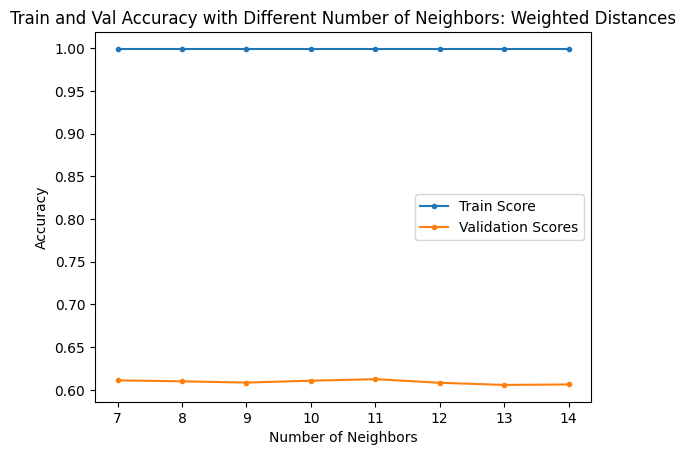

In [19]:
#plot  train and val
plt.figure()
plt.plot(num_ks, train_scores,label="Train Score",marker='.')
plt.plot(num_ks, validation_scores,label="Validation Scores",marker='.')
plt.title('Train and Val Accuracy with Different Number of Neighbors: Weighted Distances')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

I kept the same scaler but changed the weights to uniform, and the overfitting went down substantially. At k=10 was my optimal validation score, so that is the k I will use in my final model.

In [20]:
validation_scores = []
train_scores = []

num_ks = range(5,50,5)
#loop thru k's and append val and test
for k in num_ks:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled,y_train)

  train_scores.append(knn.score(X_train_scaled,y_train))
  validation_scores.append(knn.score(X_val_scaled,y_val))

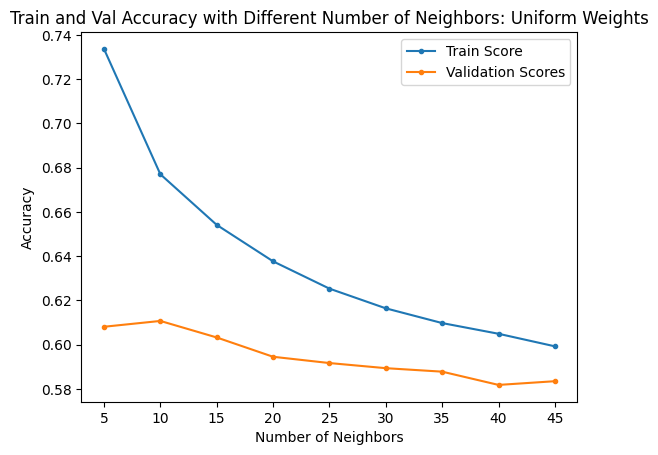

In [21]:
#plot train and val
plt.figure()
plt.plot(num_ks, train_scores,label="Train Score",marker='.')
plt.plot(num_ks, validation_scores,label="Validation Scores",marker='.')
plt.title('Train and Val Accuracy with Different Number of Neighbors: Uniform Weights')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

I saved my KNN model with the optimal hyperparameters, and again fit only on the training data. Note: the default weights is uniform which is why I didnt have to explicitly include it.

In [22]:

knn = KNeighborsClassifier(n_neighbors=10) #instantiate with 10 neighbors
knn.fit(X_train_scaled,y_train) #fit on train 
dump(knn, 'KNN.joblib') #save model


y_pred_knn = best_model_knn.predict(X_test)
optimized_score_knn = best_model_knn.score(X_test, y_test)
print('Accuracy: ', optimized_score_knn)
optimized_knn_class_report = classification_report(y_test,y_pred_knn,output_dict=True)

Accuracy:  0.6267087276550999


In [35]:
accuracy_df.loc['KNN', 'Optimized Accuracy'] = round(optimized_score_knn,2)
print('Accuracy: ', optimized_score_knn)

Accuracy:  0.6267087276550999


Adding the success metrics and saving the dataframes.

In [36]:
get_class_metrics(optimized_knn_class_report, 'optimized_knn',scores_df)

In [37]:
scores_df.to_csv('Data/scores_df2.csv')

In [38]:
accuracy_df.to_csv('Data/accuracy_df2.csv')